In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import json
from torchvision import transforms
from tqdm import tqdm
from torchvision import datasets, transforms
from IPython.display import display, clear_output
%matplotlib inline

In [2]:
class Visualizer():
    def __init__(self, num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='', tight=False, cm=None):
        self.fig, self.axs = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
        # remove ticks
        if axis_off:
          plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        # set colormap
        if cm is not None:
            plt.set_cmap(cm)
        # set supertitle
        self.fig.suptitle(title)
        if tight:
            self.fig.subplots_adjust(top=0.88)

    def add_image_subplot(self, i, j, image, normalize=False, title_str=''):
        if image.shape[0]<=3:
            image = image.permute(1, 2, 0).numpy()[:,:,::-1]
        if normalize:
            image = self.normalize_image(image)
        if len(image.shape) == 3:
            #BGR -> RGB
            image = image[:, :, ::-1]
        self.axs[i, j].imshow(image)
        self.axs[i, j].set_title(title_str)

    def show(self):
        display(self.fig)
        clear_output(wait = True)
        plt.pause(0.05)

    def add_stem_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].stem(x, y)
        self.axs[i, j].set_title(title_str)

    def add_subplot(self, i, j, data, title_str=''):
        self.axs[i, j].plot(data)
        self.axs[i, j].set_title(title_str)

    def add_subplot_xy(self, i, j, x, y, title_str=''):
        self.axs[i, j].plot(x,y)
        self.axs[i, j].set_title(title_str)

    def add_bar_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].bar(x, y)
        self.axs[i, j].set_title(title_str)

    @staticmethod
    def normalize_image(image):
        img = np.float64(image) - np.min(image)
        img /= np.max(img)
        return img

In [3]:
from dataset_configuration import prepare_dataset,Disparity_Normalization,resize_max_res_tensor

In [4]:
(train_loader, val_loader, test_loader), dataset_config_dict = prepare_dataset(
            data_name="trans10k",
            datapath="/mnt/disks/data1",
            batch_size=4,
            test_batch=1,
            datathread=4)

In [5]:
print(len(train_loader))

1250


In [6]:
for batch in train_loader:
    print(len(batch))
    print(batch[0].shape)
    print(batch[1].shape)
    print(batch[2])
    break

3
torch.Size([4, 3, 512, 512])
torch.Size([4, 512, 512])
['6435.jpg', '1543.jpg', '7352.jpg', '8700.jpg']


train_loader gives us a list of 3 elements:
 - [0] Image batch (Tensor: batch x channels x width x height)
 - [1] Mask batch (Tensor: batch x width x height)
 - [2] Filenames (List: batch)

In [7]:
def replicate_across_channels(mask):
    mask_single = mask.unsqueeze(1)
    mask_stacked = mask_single.repeat(1,3,1,1) # dim 0 is batch?
    mask_stacked = mask_stacked.float() # the dataset has it as a float
    return mask_stacked

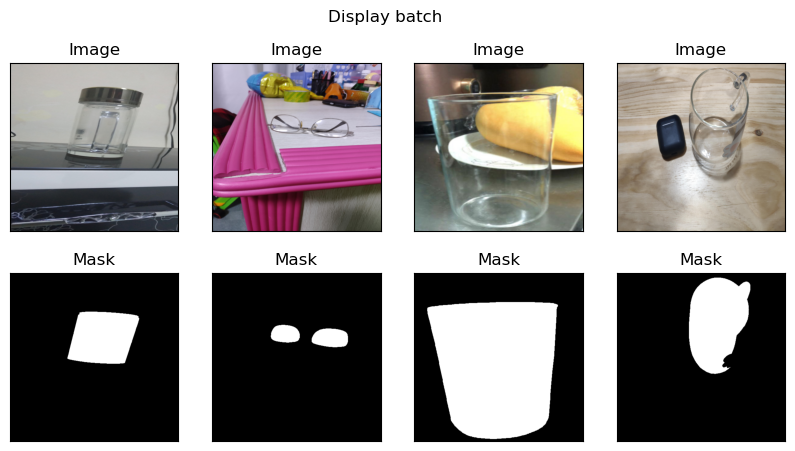

In [8]:
for batch in train_loader:
    images = batch[0]
    
    masks = batch[1]
    masks = torch.clamp(masks, 0, 1)
    masks = replicate_across_channels(masks)

    batch_size = images.shape[0]
    vis = Visualizer(2, batch_size, figsize=(10,5), title='Display batch')
    
    for i in range(batch_size):
        vis.add_image_subplot(0, i, images[i], normalize=False, title_str='Image')
        vis.add_image_subplot(1, i, masks[i], normalize=False, title_str='Mask')
    
    break

In [9]:
print(images.shape)
print(masks.shape)

torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])


In [10]:
len(train_loader)*4/32

156.25

In [11]:
from noise_samplers import pyramid_noise_like

In [12]:
masks_noise = pyramid_noise_like(masks)
print(masks_noise.min())

tensor(-4.6469)


In [13]:
import random

import torch
from torch import nn

In [14]:
def annealed_pyramid_noise_like(x, timesteps, total_steps, discount=0.8):
    b, c, w, h = x.shape # EDIT: w and h get over-written, rename for a different variant!
    u = nn.Upsample(size=(w, h), mode='bilinear')
    noise = torch.randn_like(x)
    for i in range(10):
        r = random.random()*2+2 # Rather than always going 2x, 
        w, h = max(1, int(w/(r**i))), max(1, int(h/(r**i)))
        steps = timesteps.view(-1, 1, 1, 1).expand(x.shape)
        weights = (discount * steps / total_steps) ** i
        n = u(torch.randn(b, c, w, h).to(x))
        noise += n * weights
        if w==1 or h==1: break # Lowest resolution is 1x1
    return noise/noise.std() # Scaled back to roughly unit variance

In [15]:
total_steps = 1000
timesteps = torch.randint(0, total_steps, (4,))
print(timesteps)

tensor([422, 461,  58, 408])


In [16]:
annealed_masks_noise = annealed_pyramid_noise_like(masks, timesteps, total_steps)
print(annealed_masks_noise.min())

tensor(-4.9689)


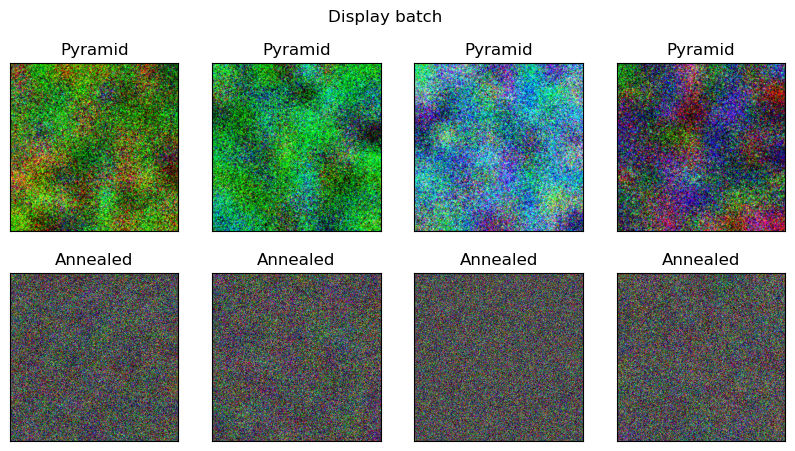

In [24]:
vis = Visualizer(2, batch_size, figsize=(10,5), title='Display batch')
for i in range(batch_size):
        vis.add_image_subplot(0, i, masks_noise[i], normalize=False, title_str='Pyramid')
        vis.add_image_subplot(1, i, annealed_masks_noise[i], normalize=False, title_str='Annealed')

In [18]:
gaussian = torch.randn_like(masks)
print(gaussian.min())

tensor(-4.9332)


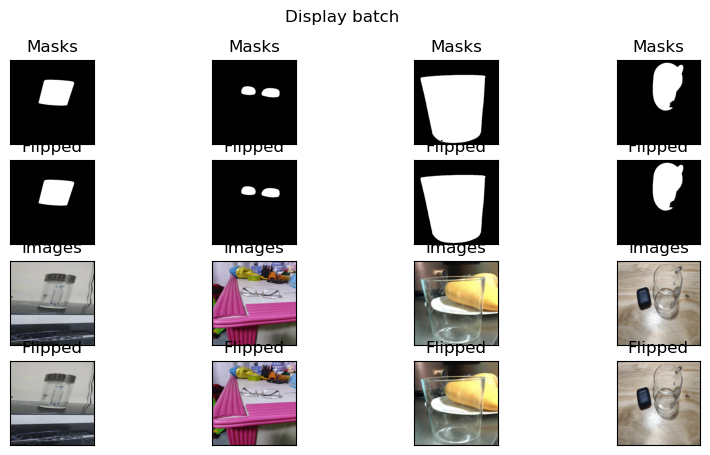

In [56]:
from torchvision.transforms import v2
randhflip = v2.RandomHorizontalFlip(p=0.5)
flipped_images, flipped_masks = torch.split(randhflip(torch.cat([images, masks],dim=1)),3,dim=1)
vis = Visualizer(4, batch_size, figsize=(10,5), title='Display batch')
for i in range(batch_size):
        vis.add_image_subplot(0, i, masks[i], normalize=False, title_str='Masks')
        vis.add_image_subplot(1, i, flipped_masks[i], normalize=False, title_str='Flipped')
        vis.add_image_subplot(2, i, images[i], normalize=False, title_str='Images')
        vis.add_image_subplot(3, i, flipped_images[i], normalize=False, title_str='Flipped')